In [1]:
import pandas as pd
import torch
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import torch
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, iirnotch, lfilter, lfilter_zi

DATA_ROOT = 'ALL EMG/My-Data'
CHANNELS = [f' EXG Channel {i}' for i in range(8)]
fs = 250
lowcut, highcut = 20, 124
notch_freq = 50

# Design filters
order = 8
nyq = 0.5 * fs

# Bandpass filter
b_band, a_band = butter(order, [lowcut / nyq, highcut / nyq], btype='band')

# Notch filter
q = 30
w0 = notch_freq / nyq
b_notch, a_notch = iirnotch(w0, q)

# Real-time-style filter function
def real_time_filter(data, b1, a1, b2, a2):
    # Apply bandpass
    zi_band = lfilter_zi(b1, a1) * data[0]
    banded, _ = lfilter(b1, a1, data, zi=zi_band)
    
    # Apply notch
    zi_notch = lfilter_zi(b2, a2) * banded[0]
    notched, _ = lfilter(b2, a2, banded, zi=zi_notch)
    
    return notched

# Process files
all_dfs = []

for folder in os.listdir(DATA_ROOT):
    folder_path = os.path.join(DATA_ROOT, folder)
    if not os.path.isdir(folder_path):
        continue

    file_path = os.path.join(folder_path, 'labeled_emg_output.txt')
    if not os.path.exists(file_path):
        continue

    try:
        df = pd.read_csv(file_path, comment='%', skiprows=0)
        if any(col not in df.columns for col in CHANNELS):
            print(f"Missing expected channels in {file_path}, skipping.")
            continue

        if 'right' in folder.lower():
            df[CHANNELS] = df[CHANNELS].iloc[:, ::-1].values

        # Remove class 0 rows *before* filtering
        df = df[df['class'] != 0]

        # Filter each channel
        for ch in CHANNELS:
            raw = df[ch].values
            filtered = real_time_filter(raw, b_band, a_band, b_notch, a_notch)
            filtered = np.clip(filtered, -600, 600)
            df[ch] = filtered

        all_dfs.append(df)
        print(f"Processed: {file_path}")

    except Exception as e:
        print(f"Error in {file_path}: {e}")

# Combine all
if all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined DataFrame shape: {full_df.shape}")
else:
    print("No valid EMG recordings were processed.")

print(f"{(len(full_df) / 250)/60:.2f} Minutes of data")

Processed: ALL EMG/My-Data/AO_m_left_2025-05-10_18-27-22/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-04-12_15-30-48/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_right_2025-05-12_21-50-38/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-05-12_21-38-38/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_left_2025-03-18_14-38-23/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-05-08_12-58-41/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-05-13_15-26-33/labeled_emg_output.txt
Processed: ALL EMG/My-Data/snr_test1_2025-05-30_16-29-05/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-04-13_14-34-18/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_right_2025-04-13_15-07-50/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-05-06_18-34-45/labeled_emg_output.txt
Processed: ALL EMG/My-Data/AO_m_left_2025-05-06_18-51-09/labeled_emg_output.txt
Processed: ALL EMG/My-Data/snr_test2_202

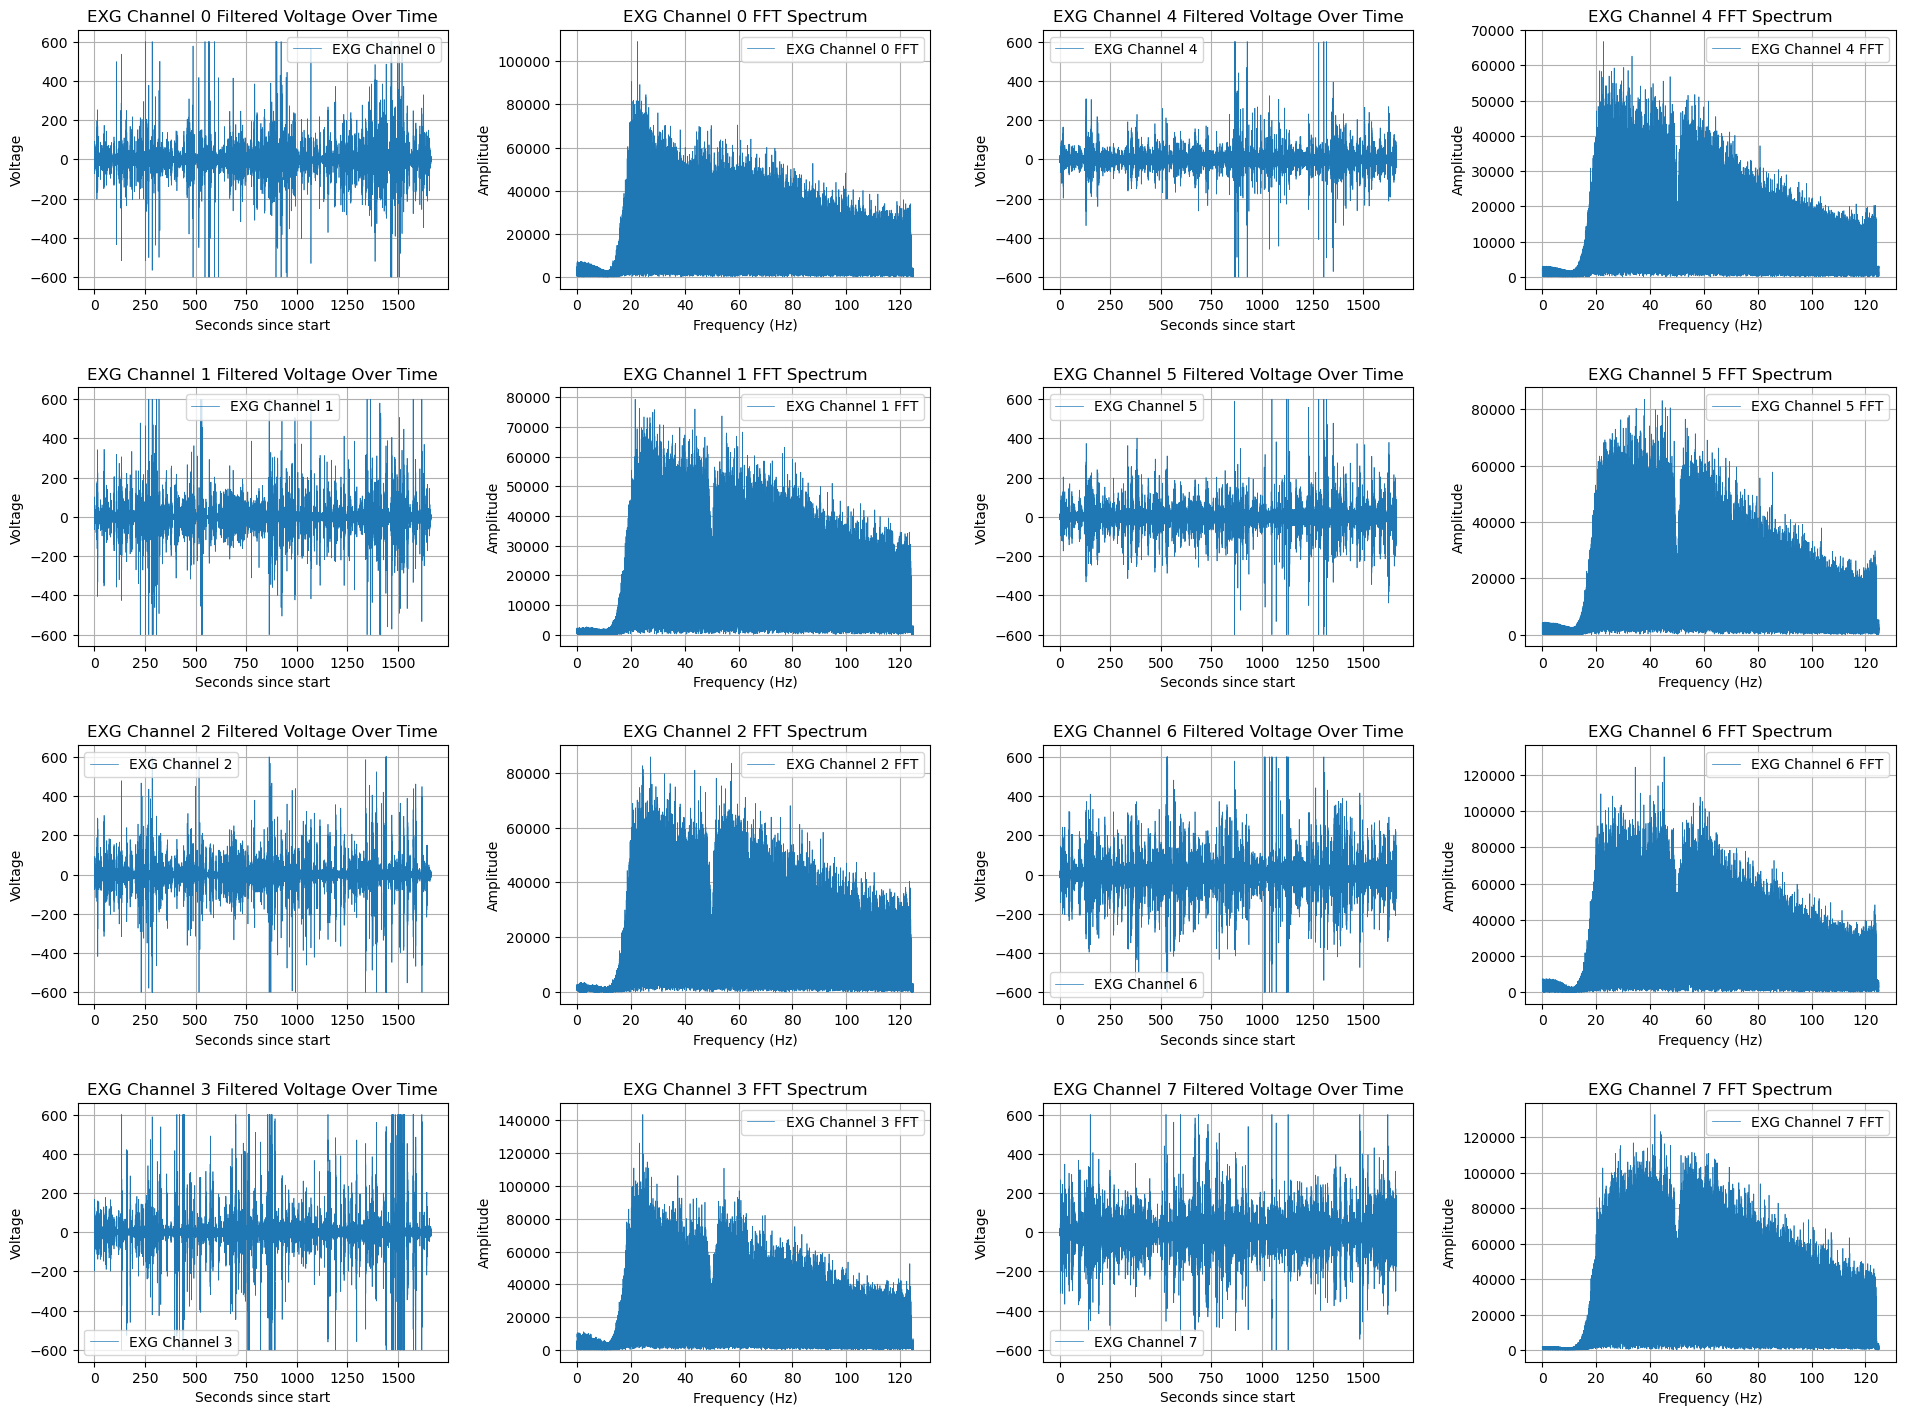

In [3]:
data = full_df

# Compute FFT
def compute_fft(data, fs):
    N = len(data)
    freqs = np.fft.rfftfreq(N, 1/fs)
    fft_values = np.abs(np.fft.rfft(data))
    return freqs, fft_values

# Compute the x-axis values with  sampling rate of 250 Hz
total_samples = len(data)
time_stamps = np.linspace(0, total_samples / fs, total_samples)

# Setup the figure and axes for subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))  # Adjust figure size and columns
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Plot each EXG channel
for i in range(8):
    channel_name = f' EXG Channel {i}'

    row = i % 4  # Rows cycle through 0-3
    col_time = 2 * (i // 4)      # Time-domain plot in first column of each group
    col_fft = col_time + 1

    # Time-domain plot
    ax_time = axes[row, col_time]
    ax_time.plot(time_stamps, data[channel_name], label=channel_name.strip(), linewidth=0.5)
    ax_time.set_title(channel_name.strip() + ' Filtered Voltage Over Time')
    ax_time.set_xlabel('Seconds since start')
    ax_time.set_ylabel('Voltage')
    ax_time.legend()
    ax_time.grid(True)

    # Frequency-domain plot-
    ax_fft = axes[row, col_fft]
    freqs, fft_values = compute_fft(data[channel_name], fs)
    ax_fft.plot(freqs, fft_values, label=f'{channel_name.strip()} FFT', linewidth=0.5)
    ax_fft.set_title(channel_name.strip() + ' FFT Spectrum')
    ax_fft.set_xlabel('Frequency (Hz)')
    ax_fft.set_ylabel('Amplitude')
    ax_fft.legend()
    ax_fft.grid(True)

# Show the plot
plt.show()

### define feature extractors

In [4]:
import numpy as np
from scipy.stats import kurtosis, skew

def iemg(x):
    """Integrated EMG (IEMG)"""
    return np.sum(np.abs(x))

def var(x):
    """Variance"""
    return np.var(x, ddof=1)

def rms(x):
    """Root Mean Square (RMS)"""
    return np.sqrt(np.mean(x**2))

def ln_rms(x):
    """Log RMS"""
    return np.log(rms(x) + 1e-10)  # Add epsilon to avoid log(0)

def kurt(x):
    """Kurtosis"""
    return kurtosis(x, fisher=True)

def skewness(x):
    """Skewness"""
    return skew(x)

def aac(x):
    """Average Amplitude Change (AAC)"""
    return np.sum(np.abs(np.diff(x))) / len(x)

def mav(x):
    """Mean Absolute Value (MAV)"""
    return np.mean(np.abs(x))

def mav1(x, threshold_ratio=0.25):
    """Modified Mean Absolute Value 1 (MAV1)"""
    th = threshold_ratio * np.max(np.abs(x))
    return np.mean([abs(xi) if abs(xi) > th else 0 for xi in x])

def mav2(x, threshold_ratio=0.25):
    """Modified Mean Absolute Value 2 (MAV2)"""
    th = threshold_ratio * np.max(np.abs(x))
    return np.mean([abs(xi) if abs(xi) < th else 0 for xi in x])

def mavs(x, segment=10):
    """Mean Absolute Value Slope (MAVS)"""
    split = np.array_split(np.abs(x), segment)
    means = [np.mean(seg) for seg in split]
    return np.mean(np.abs(np.diff(means))) if len(means) > 1 else 0

def ssc(x):
    """Slope Sign Changes (SSC)"""
    return np.sum(np.diff(np.sign(np.diff(x))) != 0)

def ssi(x):
    """Simple Square Integral (SSI)"""
    return np.sum(x**2)

def tm(x, order=4):
    """Absolute Temporal Moment (TM)"""
    return np.mean(np.abs(x)**order)

def wamp(x, threshold=10):
    """Willison Amplitude (WAMP)"""
    return np.sum(np.abs(np.diff(x)) >= threshold)

def myop(x, threshold=16):
    """Myopulse Percentage Rate (MYOP)"""
    return np.sum(np.abs(x) > threshold)

def zc(x, threshold=10):
    """Zero Crossings (ZC)"""
    return np.sum((x[:-1] * x[1:] < 0) & (np.abs(x[:-1] - x[1:]) >= threshold))

feature_extractors = [
    iemg, var, rms, ln_rms, kurt, skewness,
    aac, mav1, mav2, mav, mavs,
    ssc, ssi, tm, wamp, myop, zc
]


### helper functions and simple models for quick verification tests

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import combinations

# ====== Augmentation ======
def add_noise(x, min_noise_level=0.1, max_noise_level=0.7):
    factor = np.random.uniform(min_noise_level, max_noise_level)
    return x + np.random.normal(0, factor, x.shape)

def scale_amplitude(x, min_scale=0.7, max_scale=1.3):
    factor = np.random.uniform(min_scale, max_scale)
    return x * factor

def augment_window(window):
    window_aug = window.copy()
    for i in range(8):
        x = window_aug[f' EXG Channel {i}'].values
        x = scale_amplitude(add_noise(x))
        window_aug[f' EXG Channel {i}'] = x
    return window_aug

def extract_features(window, feature_extractors=[ln_rms, aac, mavs, ssc, wamp, skewness, ssi]):
    features = []
    channel_data = []

    for i in range(8):
        x = window[f' EXG Channel {i}'].values
        channel_data.append(x)
        for extractor in feature_extractors:
            result = extractor(x)
            features.extend(result if isinstance(result, (list, np.ndarray)) else [result])

    channel_data = np.array(channel_data)
    for i, j in combinations(range(8), 2):
        features.append(np.corrcoef(channel_data[i], channel_data[j])[0, 1])

    return features

# * no more 3 way split, 2 is enough as we want to actually use this model in the system
# ====== Dataset Preparation ======
def prepare_dataset(data, sampling_rate=250, window_duration=0.5, overlap_percentage=0.125, n_augments=0, test_size=0.3):
    window_size = int(window_duration * sampling_rate)
    step_size = int(window_size * (1 - overlap_percentage))

    X_raw, y_raw = [], []
    num_skipepd = 0
    for start in range(0, len(data) - window_size, step_size):
        window = data.iloc[start:start + window_size]
        try:
            label_counts = window['class'].value_counts(normalize=True)
            dominant_label = label_counts.idxmax()
            if label_counts[dominant_label] < 0.75: 
                num_skipepd += 1
                continue  # Skip if dominant label doesn't cover at least 75%
            label = window['class'].mode()[0]
            X_raw.append(window)
            y_raw.append(label)
        except:
            continue
    print(f"Skipped {num_skipepd} windows because they aren't at least 75% belonging to the mode class. This is {round(num_skipepd*100 / (len(X_raw) + num_skipepd), 2)}% of data")

    # Now split windows (not features) to prevent leakage
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y_raw, test_size=test_size, random_state=42, stratify=y_raw)

    # Extract features
    X_train = [extract_features(w) for w in X_train_raw]
    X_test = [extract_features(w) for w in X_test_raw]

    # Apply augmentations ONLY on training set
    if n_augments > 0:
        for window, label in zip(X_train_raw, y_train):
            for _ in range(n_augments):
                aug_window = augment_window(window)
                X_train.append(extract_features(aug_window))
                y_train.append(label)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


X_train, y_train, X_test, y_test = prepare_dataset(data, n_augments=0, window_duration=0.128, overlap_percentage=0.75, test_size=0.15)

y_train -= 1
y_test -= 1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== Convert labels to one-hot ====
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Total number of examples: {len(X_train) + len(X_test)}")

2025-06-21 21:44:16.065211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 21:44:16.398332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-21 21:44:17.876871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Skipped 741 windows because they aren't at least 75% belonging to the mode class. This is 1.43% of data
Total number of examples: 51220


### best model architecture from offline classification testing

Epoch 1/200


/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2722/2722 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8029 - loss: 0.5802 - val_accuracy: 0.9150 - val_loss: 0.2463
Epoch 2/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9018 - loss: 0.2893 - val_accuracy: 0.9306 - val_loss: 0.1938
Epoch 3/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9173 - loss: 0.2381 - val_accuracy: 0.9379 - val_loss: 0.1721
Epoch 4/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9287 - loss: 0.2057 - val_accuracy: 0.9426 - val_loss: 0.1620
Epoch 5/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9346 - loss: 0.1852 - val_accuracy: 0.9485 - val_loss: 0.1474
Epoch 6/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9399 - loss: 0.1716 - val_accuracy: 0.9530 - val_loss: 0.1361
Epoch 7/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - accuracy: 0.9449 - loss: 0.1608 - val_accuracy: 0.9569 - val_loss: 0.1265
Epoch 8/200
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9447 - loss: 0.1568 - va

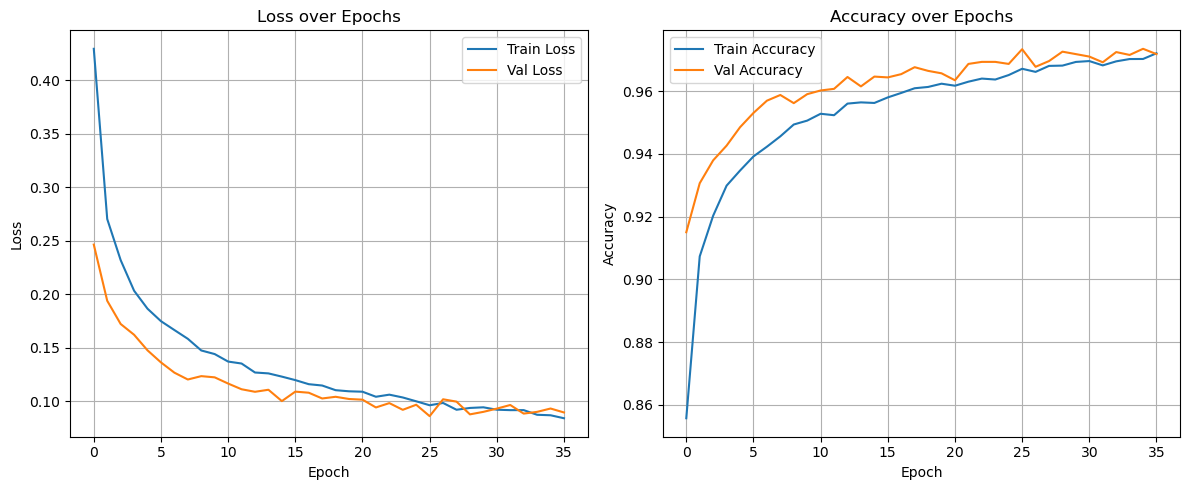

In [6]:
# ==== Build MLP ====
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

# ==== Train ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_cat,
                    validation_data=(X_test_scaled, y_test_cat),
                    epochs=200,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1,)

# Evaluate
val_loss, val_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# ==== Plot loss and accuracy ====
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import joblib

joblib.dump(scaler, "mlp_emg_scaler.pkl")
model.save('mlp_AYMAN.h5')

In [8]:
np.argmax(model.predict(np.array([X_train_scaled[10]])), axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


4

In [9]:
y_train[10]

4